<h2>Importante</h2>
Non tutti i modelli elencati sono stati salvati su file!<br>
Controllare le cartelle presenti all'interno della cartella condivisa nel drive per vericare l'effettiva presenza prima di porvare ad eseguire il comando per il caricamento di un modello da file

In [1]:
import numpy as np
import os
import skimage
from skimage.color import rgb2gray
import sklearn
import sklearn.model_selection
import sklearn.svm
import sklearn.linear_model
import sklearn.preprocessing
import sklearn.pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import sklearn.ensemble
import sklearn.tree
import sklearn.neighbors
%matplotlib inline 
import matplotlib.pyplot as plt
import cv2
import pybboxes as pbx
import torch
import pickle
from torchinfo import summary

<h3>Utility Functions</h3>

In [2]:
def swap_coord(box_coord):
        return [box_coord[0],box_coord[2],box_coord[1],box_coord[3]]

def resize_bbox_coord(box_coord,height,width,new_size):
        y_ = height
        x_ = width
        x_scale = new_size / x_
        y_scale = new_size / y_

        box_coord[0] = int(round(box_coord[0]) * x_scale)
        box_coord[1] = int(round(box_coord[1]) * y_scale)
        box_coord[2] = int(round(box_coord[2]) * x_scale)
        box_coord[3] = int(round(box_coord[3]) * y_scale)

        return box_coord

<h2>Caricamento delle immagini e delle label</h2>
<p>
<h3>Impostare la variabile 'flag_img_e_bbox' a false se si vuole caricare l'intero dataset</h3>
Impostato a false quando sono stati addestrati i modelli con kernel 'poly', 'rbf' e 'sigmoid' passando come parametri solamente i 3 valori calcolati dalla bounding box
</p>
<br>
<p>
<h3>Impostare la variabile 'flag_img_e_bbox' a true se si vuole caricare l'intero dataset escluse le cartelle Subject.2 e Subject.5</h3>
Impostato a true quando è stato addestrato il modello con kernel 'linear' passando come parametri sia l'immagine che i 3 valori calcolati dalla bounding box
</p>
<br>
<p>
<h3>Ottenere solo dati bounding box oppure anche immagine</h3>
Commentare le righe di codice 56 e 99 per tener conto solamente dei 3 valori calcolati dalla bounding box<br>
Tenere tali righe di codice per considerare anche l'immagine oltre che ai 3 valori calcolati dalla bounding box
</p>

In [ ]:
path = "C:/Users/Alebo/Desktop/CAUCAFall_FPDS_merge"

IMAGE_SIZE = 192 # dimensione di ogni immagine sara' IMAGE_SIZE * IMAGE_SIZE

x = []
y = []
inner_dirs = []
nomefile = ""
bbox_coord = []
lines = []
flag_img_e_bbox = False # impostare a false se si vuole utilizzare tutto il dataset, impostare a true per rimuovere cartelle "Subject.2" e "Subject.5 utilizzato per ottenere risultati dal fit del kernel linear passando img e dati bbox

directories = os.listdir(path)


for dirs in directories:
    full_path = path + "/" + dirs
    inner_dirs = os.listdir(full_path)
    if flag_img_e_bbox==False:  # controlla flag per vedere se caricare da tutte le cartelle o no
        for dir in inner_dirs:
            files_path = full_path + "/" + dir
            files = os.listdir(files_path)
            for file in files:
                if file.split('.')[0] == nomefile:
                    continue
                else:
                    nomefile = file.split('.')[0]
                with open(files_path + "/" + nomefile + ".txt") as ff:
                    lines = ff.readlines()
                for line in lines:
                    img_and_bbox = []
                    if(line.split()[0] == '-1'):
                        y.append('0')
                    else:
                        y.append(line.split()[0])
                    bbox_coord = line.split()[1:] # salva i 4 valori della bounding box 
                    bbox_coord = [float(x) for x in bbox_coord] # converte da string a float


                    img = cv2.cvtColor(cv2.imread(files_path + "/" + nomefile + ".png"), cv2.COLOR_BGR2GRAY)

                    if "Subject" in files_path:
                        bbox_coord =  pbx.convert_bbox(bbox_coord, from_type="yolo", to_type="voc", image_size=(IMAGE_SIZE,IMAGE_SIZE))
                    else:
                        bbox_coord = swap_coord(bbox_coord)
                        bbox_coord = resize_bbox_coord(bbox_coord,img.shape[0],img.shape[1],IMAGE_SIZE)
                    
                    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))

                    bbox_aspect_ratio = (bbox_coord[2]-bbox_coord[0])/(bbox_coord[3]-bbox_coord[1])

                    normalized_bbox_width = (int(bbox_coord[2])-int(bbox_coord[0]))/(img.shape)[1]

                    normalized_bbox_bottom_cord = 1 - bbox_coord[3]/(img.shape)[0]

                    #img_and_bbox = img.flatten().tolist() #commentare per considerare solo dati provenienti da analisi bounding box
                    img_and_bbox.append(bbox_aspect_ratio)
                    img_and_bbox.append(normalized_bbox_width) #inserimento valori calcolati da coordinate bounding box in array contenente dati immagine corrispondente
                    img_and_bbox.append(normalized_bbox_bottom_cord)
                    x.append(img_and_bbox)

    elif (dirs != "Subject.2" and dirs != "Subject.5"):
        for dir in inner_dirs:
            files_path = full_path + "/" + dir
            files = os.listdir(files_path)
            for file in files:
                if file.split('.')[0] == nomefile:
                    continue
                else:
                    nomefile = file.split('.')[0]
                with open(files_path + "/" + nomefile + ".txt") as ff:
                    lines = ff.readlines()
                for line in lines:
                    img_and_bbox = []
                    if(line.split()[0] == '-1'):
                        y.append('0')
                    else:
                        y.append(line.split()[0])
                    bbox_coord = line.split()[1:] # salva i 4 valori della bounding box 
                    bbox_coord = [float(x) for x in bbox_coord] # converte da string a float


                    img = cv2.cvtColor(cv2.imread(files_path + "/" + nomefile + ".png"), cv2.COLOR_BGR2GRAY)

                    if "Subject" in files_path:
                        bbox_coord =  pbx.convert_bbox(bbox_coord, from_type="yolo", to_type="voc", image_size=(IMAGE_SIZE,IMAGE_SIZE))
                    else:
                        bbox_coord = swap_coord(bbox_coord)
                        bbox_coord = resize_bbox_coord(bbox_coord,img.shape[0],img.shape[1],IMAGE_SIZE)
                    
                    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))

                    bbox_aspect_ratio = (bbox_coord[2]-bbox_coord[0])/(bbox_coord[3]-bbox_coord[1])

                    normalized_bbox_width = (int(bbox_coord[2])-int(bbox_coord[0]))/(img.shape)[1]

                    normalized_bbox_bottom_cord = 1 - bbox_coord[3]/(img.shape)[0]

                    #img_and_bbox = img.flatten().tolist() #commentare per considerare solo dati provenienti da analisi bounding box
                    img_and_bbox.append(bbox_aspect_ratio)
                    img_and_bbox.append(normalized_bbox_width) #inserimento valori calcolati da coordinate bounding box in array contenente dati immagine corrispondente
                    img_and_bbox.append(normalized_bbox_bottom_cord)
                    x.append(img_and_bbox)

x2 = np.asarray(x) #trasformo in array di numpy
y2 = np.asarray(y) #trasformo in array di numpy

<h3>Suddivisione in train e test</h3>

In [ ]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x2,y2, test_size = 0.25, random_state = 4)

Controllo di quanti elementi sono presenti in ogni array

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

<h3>Creazione classica dei classifier</h3>

In [ ]:
classifier_linear = sklearn.svm.SVC(kernel = 'linear', gamma=2, C=128)

In [ ]:
classifier_poly = sklearn.svm.SVC(kernel = 'poly', gamma=2, C=128)

In [ ]:
classifier_rbf = sklearn.svm.SVC(kernel = 'rbf', gamma=2, C=128)

In [ ]:
classifier_sigmoid = sklearn.svm.SVC(kernel = 'sigmoid', gamma=2, C=128)

In [ ]:
classifier_linear = sklearn.svm.LinearSVC(verbose=1, C=128, loss='hinge')

SGD

In [ ]:
classifier_SGD_hinge =  sklearn.pipeline.make_pipeline(sklearn.preprocessing.StandardScaler(),sklearn.linear_model.SGDClassifier(max_iter=10000, alpha=0.00001, verbose=3, n_jobs=-1))

In [ ]:
classifier_SGD_squared_hinge =  sklearn.pipeline.make_pipeline(sklearn.preprocessing.StandardScaler(),sklearn.linear_model.SGDClassifier(loss='squared_hinge', max_iter=10000, alpha=0.00001, verbose=3, n_jobs=-1))

Tree Classifier

In [ ]:
classifier_tree_gini = sklearn.tree.DecisionTreeClassifier() 

In [ ]:
classifier_tree_entropy = sklearn.tree.DecisionTreeClassifier(criterion='entropy')

KNeighbors

In [ ]:
classifier_kneighbors = sklearn.neighbors.KNeighborsClassifier(n_jobs=-1)

Random Forest Classifier

In [ ]:
classifier_random_forest_gini = sklearn.ensemble.RandomForestClassifier(verbose = 3, n_jobs=-1)

In [ ]:
classifier_random_forest_entropy = sklearn.ensemble.RandomForestClassifier(criterion='entropy', verbose = 3, n_jobs=-1)

<h3>Train dei classifier</h3>

<h4>kernel linear</h4>

In [ ]:
classifier_linear.fit(x_train, y_train) # train del classifier

eseguire se si vuole salvare il modello addestrato con immagine e valori calcolati da bbox su file

In [ ]:
filename = 'classifier_linear_img_and_bbox.sav' #salvataggio modello bbox e immagine
pickle.dump(classifier_linear, open(filename, 'wb'))

eseguire se si vuole salvare il modello addestrato con soli valori calcolati da bounding box su file

In [ ]:
filename = 'classifier_linear_bbox_only.sav' #salvataggio modello bbox e immagine
pickle.dump(classifier_linear, open(filename, 'wb'))

<h4>kernel poly</h4>

In [ ]:
classifier_poly.fit(x_train,y_train)

eseguire se si vuole salvare il modello addestrato con immagine e valori calcolati da bbox su file

In [ ]:
filename = 'classifier_poly_img_and_bbox.sav' #salvataggio modello bbox e immagine
pickle.dump(classifier_poly, open(filename, 'wb'))

eseguire se si vuole salvare il modello addestrato con soli valori calcolati da bounding box su file

In [ ]:
filename = 'classifier_poly_bbox_only.sav' #salvataggio modello bbox e immagine
pickle.dump(classifier_poly, open(filename, 'wb'))

<h4>kernel rbf</h4>

In [ ]:
classifier_rbf.fit(x_train,y_train)

eseguire se si vuole salvare il modello addestrato con immagine e valori calcolati da bbox su file

In [ ]:
filename = 'classifier_rbf_img_and_bbox.sav' #salvataggio modello bbox e immagine
pickle.dump(classifier_rbf, open(filename, 'wb'))

eseguire se si vuole salvare il modello addestrato con soli valori calcolati da bounding box su file

In [ ]:
filename = 'classifier_rbf_bbox_only.sav'#salvataggio modello solo bbox
pickle.dump(classifier_rbf, open(filename, 'wb'))

<h4>kernel sigmoid</h4>

In [ ]:
classifier_sigmoid.fit(x_train,y_train)

eseguire se si vuole salvare il modello addestrato con immagine e valori calcolati da bbox su file

In [ ]:
filename = 'classifier_sigmoid_img_and_bbox.sav' #salvataggio modello bbox e immagine
pickle.dump(classifier_sigmoid, open(filename, 'wb'))

eseguire se si vuole salvare il modello addestrato con soli valori calcolati da bounding box su file

In [ ]:
filename = 'classifier_sigmoid_bbox_only.sav'#salvataggio modello solo bbox
pickle.dump(classifier_sigmoid, open(filename, 'wb'))

<h4>SGD Classifier</h4> 

loss = 'hinge'

In [ ]:
classifier_SGD_hinge.fit(x_train,y_train)

In [ ]:
filename = 'classifier_SGD_hinge_img_and_bbox.sav' #salvataggio modello bbox e immagine
pickle.dump(classifier_SGD_hinge, open(filename, 'wb'))

In [ ]:
filename = 'classifier_SGD_hinge_bbox_only.sav'#salvataggio modello solo bbox
pickle.dump(classifier_SGD_hinge, open(filename, 'wb'))

loss = 'squared_hinge'

In [ ]:
classifier_SGD_squared_hinge.fit(x_train,y_train)

In [ ]:
filename = 'classifier_SGD_squared_hinge_img_and_bbox.sav' #salvataggio modello bbox e immagine
pickle.dump(classifier_SGD_squared_hinge, open(filename, 'wb'))

In [ ]:
filename = 'classifier_SGD_squared_hinge_bbox_only.sav'#salvataggio modello solo bbox
pickle.dump(classifier_SGD_squared_hinge, open(filename, 'wb'))

<h4>Decision Tree Classifier</h4>

criterion = gini

In [ ]:
classifier_tree_gini.fit(x_train,y_train)

In [ ]:
filename = 'classifier_tree_gini_img_and_bbox.sav'
pickle.dump(classifier_tree_gini, open(filename,'wb'))

In [ ]:
filename = 'classifier_tree_gini_bbox_only.sav'
pickle.dump(classifier_tree_gini, open(filename,'wb'))

criterion = entropy

In [ ]:
classifier_tree_entropy.fit(x_train,y_train)

In [ ]:
filename = 'classifier_tree_entropy_img_and_bbox.sav'
pickle.dump(classifier_tree_entropy, open(filename,'wb'))

In [ ]:
filename = 'classifier_tree_entropy_bbox_only.sav'
pickle.dump(classifier_tree_entropy, open(filename,'wb'))

<h4>KNeighbors classifier</h4>

In [ ]:
classifier_kneighbors.fit(x_train,y_train)

In [ ]:
filename = 'classifier_kneighbors_img_and_bbox.sav'
pickle.dump(classifier_kneighbors, open(filename,'wb'))

In [ ]:
filename = 'classifier_kneighbors_bbox_only.sav'
pickle.dump(classifier_kneighbors, open(filename,'wb'))

<h4>Random Forest Classifier</h4>

criterion = gini

In [ ]:
classifier_random_forest_gini.fit(x_train,y_train)

In [ ]:
filename = 'classifier_random_forest_gini_img_and_bbox.sav'
pickle.dump(classifier_random_forest_gini, open(filename,'wb'))

In [ ]:
filename = 'classifier_random_forest_gini_bbox_only.sav'
pickle.dump(classifier_random_forest_gini, open(filename,'wb'))

criterion = entropy

In [ ]:
classifier_random_forest_entropy.fit(x_train,y_train)

In [ ]:
filename = 'classifier_random_forest_entropy_img_and_bbox.sav'
pickle.dump(classifier_random_forest_entropy, open(filename,'wb'))

In [ ]:
filename = 'classifier_random_forest_entropy_bbox_only.sav'
pickle.dump(classifier_random_forest_entropy, open(filename,'wb'))

<h3>Test dei classifier</h3>
Attenzione, non tutti i modelli già addestrati sono presenti, controllare la cartella contenente tali modelli

<h4>kernel linear</h4>

eseguire per caricare modello con kernel linear già addestrato su bounding box e immagine

In [ ]:
filename = 'classifier_linear_img_and_bbox.sav'
classifier_linear = pickle.load(open(filename, 'rb'))  # caricamento modello già addestrato su bbox e immagine

eseguire per caricare modello con kernel linear già addestrato sui soli dati calcolati da bounding box

In [3]:
filename = 'classifier_linear_bbox_only.sav'
classifier_linear = pickle.load(open(filename, 'rb'))  # caricamento modello già addestrato solo su parametri calcolati dalla bounding box

Test del modello e stampa dei risultati 

In [ ]:
y_predict_linear = classifier_linear.predict(x_test) # test del classifier

print(classifier_linear)

print(classification_report(y_test, y_predict_linear)) # print delle prestazioni

cmx = confusion_matrix(y_test, y_predict_linear, labels=['0','1'])

plt.imshow(cmx)
plt.xticks([])
plt.yticks([])
plt.colorbar()

print('Percentage correct: ', 100*np.sum(y_predict_linear == y_test)/len(y_test))

<h4>kernel poly</h4>

eseguire per caricare modello con kernel poly già addestrato su bounding box e immagine

In [ ]:
filename = 'classifier_poly_img_and_bbox.sav'
classifier_poly = pickle.load(open(filename, 'rb'))  # caricamento modello già addestrato su bbox e immagine

eseguire per caricare modello con kernel poly già addestrato sui soli dati calcolati da bounding box

In [4]:
filename = 'classifier_poly_bbox_only.sav'
classifier_poly = pickle.load(open(filename, 'rb'))  # caricamento modello già addestrato solo su parametri calcolati dalla bounding box

Test del modello e stampa dei risultati 

In [ ]:
y_predict_poly = classifier_poly.predict(x_test) # test del classifier

print(classifier_poly)

print(classification_report(y_test, y_predict_poly)) # print delle prestazioni

cmx = confusion_matrix(y_test, y_predict_poly, labels=['0','1'])

plt.imshow(cmx)
plt.xticks([])
plt.yticks([])
plt.colorbar()

print('Percentage correct: ', 100*np.sum(y_predict_poly == y_test)/len(y_test))

<h4>kernel rbf</h4>

eseguire per caricare modello con kernel rbf già addestrato su bounding box e immagine

In [ ]:
filename = 'classifier_rbf_img_and_bbox.sav'
classifier_rbf = pickle.load(open(filename, 'rb'))  # caricamento modello già addestrato su bbox e immagine

eseguire per caricare modello con kernel rbf già addestrato sui soli dati calcolati da bounding box

In [5]:
filename = 'classifier_rbf_bbox_only.sav'
classifier_rbf = pickle.load(open(filename, 'rb'))  #caricamento modello già addestrato solo su parametri calcolati dalla bounding box

Test del modello e stampa dei risultati 

In [ ]:
y_predict_rbf = classifier_rbf.predict(x_test) # test del classifier

print(classifier_rbf)

print(classification_report(y_test, y_predict_rbf)) # print delle prestazioni

cmx = confusion_matrix(y_test, y_predict_rbf, labels=['0','1'])

plt.imshow(cmx)
plt.xticks([])
plt.yticks([])
plt.colorbar()

print('Percentage correct: ', 100*np.sum(y_predict_rbf == y_test)/len(y_test))

<h4>kernel sigmoid</h4>

eseguire per caricare modello con kernel sigmoid già addestrato su bounding box e immagine

In [ ]:
filename = 'classifier_sigmoid_img_and_bbox.sav'
classifier_sigmoid = pickle.load(open(filename, 'rb'))  # caricamento modello già addestrato su bbox e immagine

eseguire per caricare modello con kernel sigmoid già addestrato sui soli dati calcolati da bounding box

In [6]:
filename = 'classifier_sigmoid_bbox_only.sav'
classifier_sigmoid = pickle.load(open(filename, 'rb'))  #caricamento modello già addestrato solo su parametri calcolati dalla bounding box

Test del modello e stampa dei risultati 

In [ ]:
y_predict_sigmoid = classifier_sigmoid.predict(x_test) # test del classifier

print(classifier_sigmoid)

print(classification_report(y_test, y_predict_sigmoid)) # print delle prestazioni

cmx = confusion_matrix(y_test, y_predict_sigmoid, labels=['0','1'])

plt.imshow(cmx)
plt.xticks([])
plt.yticks([])
plt.colorbar()

print('Percentage correct: ', 100*np.sum(y_predict_sigmoid == y_test)/len(y_test))

<h4>SGD Classifier</h4>

loss = 'hinge'

eseguire per caricare modello SGD loss hinge già addestrato su bounding box e immagine

In [ ]:
filename = 'classifier_SGD_hinge_img_and_bbox.sav'
classifier_SGD_hinge = pickle.load(open(filename, 'rb'))  # caricamento modello già addestrato su bbox e immagine

eseguire per caricare modello SGD loss hinge già addestrato sui soli dati calcolati da bounding box

In [7]:
filename = 'classifier_SGD_hinge_bbox_only.sav'
classifier_SGD_hinge = pickle.load(open(filename, 'rb'))  #caricamento modello già addestrato solo su parametri calcolati dalla bounding box

In [ ]:
y_predict_hinge = classifier_SGD_hinge.predict(x_test) # test del classifier

print(classifier_SGD_hinge)

print(classification_report(y_test, y_predict_hinge)) # print delle prestazioni

cmx = confusion_matrix(y_test, y_predict_hinge, labels=['0','1'])

plt.imshow(cmx)
plt.xticks([])
plt.yticks([])
plt.colorbar()

print('Percentage correct: ', 100*np.sum(y_predict_hinge == y_test)/len(y_test))

loss = 'squared_hinge'

eseguire per caricare modello SGD loss squared hinge già addestrato su bounding box e immagine

In [ ]:
filename = 'classifier_SGD_squared_hinge_img_and_bbox.sav'
classifier_SGD_squared_hinge = pickle.load(open(filename, 'rb'))  # caricamento modello già addestrato su bbox e immagine

eseguire per caricare modello SGD loss squared hinge già addestrato sui soli dati calcolati da bounding box

In [8]:
filename = 'classifier_SGD_squared_hinge_bbox_only.sav'
classifier_SGD_squared_hinge = pickle.load(open(filename, 'rb'))  #caricamento modello già addestrato solo su parametri calcolati dalla bounding box

In [ ]:
y_predict_squared_hinge = classifier_SGD_squared_hinge.predict(x_test) # test del classifier

print(classifier_SGD_squared_hinge)

print(classification_report(y_test, y_predict_squared_hinge)) # print delle prestazioni

cmx = confusion_matrix(y_test, y_predict_squared_hinge, labels=['0','1'])

plt.imshow(cmx)
plt.xticks([])
plt.yticks([])
plt.colorbar()

print('Percentage correct: ', 100*np.sum(y_predict_squared_hinge == y_test)/len(y_test))

<h4>Decision Tree</h4>

criterion = gini

eseguire per caricare modello decision tree criterion gini già addestrato su bounding box e immagine

In [ ]:
filename = 'classifier_tree_gini_img_and_bbox.sav'
classifier_tree_gini = pickle.load(open(filename, 'rb'))  # caricamento modello già addestrato su bbox e immagine

eseguire per caricare modello decision tree criterion gini già addestrato sui soli dati calcolati da bounding box

In [9]:
filename = 'classifier_tree_gini_bbox_only.sav'
classifier_tree_gini = pickle.load(open(filename, 'rb'))  #caricamento modello già addestrato solo su parametri calcolati dalla bounding box

In [ ]:
y_predict_gini = classifier_tree_gini.predict(x_test) # test del classifier

print(classifier_tree_gini)

print(classification_report(y_test, y_predict_gini)) # print delle prestazioni

cmx = confusion_matrix(y_test, y_predict_gini, labels=['0','1'])

plt.imshow(cmx)
plt.xticks([])
plt.yticks([])
plt.colorbar()

print('Percentage correct: ', 100*np.sum(y_predict_gini == y_test)/len(y_test))

criterion = entopy

eseguire per caricare modello decision tree criterion entropy già addestrato su bounding box e immagine

In [ ]:
filename = 'classifier_tree_entropy_img_and_bbox.sav'
classifier_tree_entropy = pickle.load(open(filename, 'rb'))  # caricamento modello già addestrato su bbox e immagine

eseguire per caricare modello decision tree criterion entropy già addestrato sui soli dati calcolati da bounding box

In [10]:
filename = 'classifier_tree_entropy_bbox_only.sav'
classifier_tree_entropy = pickle.load(open(filename, 'rb'))  #caricamento modello già addestrato solo su parametri calcolati dalla bounding box

In [ ]:
y_predict_entropy = classifier_tree_entropy.predict(x_test) # test del classifier

print(classifier_tree_entropy)

print(classification_report(y_test, y_predict_entropy)) # print delle prestazioni

cmx = confusion_matrix(y_test, y_predict_entropy, labels=['0','1'])

plt.imshow(cmx)
plt.xticks([])
plt.yticks([])
plt.colorbar()

print('Percentage correct: ', 100*np.sum(y_predict_entropy == y_test)/len(y_test))

<h4>KNeighbors classifier</h4>

eseguire per caricare modello KNeighbors già addestrato su bounding box e immagine

In [ ]:
filename = 'classifier_kneighbors_img_and_bbox.sav'
classifier_kneighbors = pickle.load(open(filename, 'rb'))  # caricamento modello già addestrato su bbox e immagine

eseguire per caricare modello KNeighbors già addestrato sui soli dati calcolati da bounding box

In [11]:
filename = 'classifier_kneighbors_bbox_only.sav'
classifier_kneighbors = pickle.load(open(filename, 'rb'))  #caricamento modello già addestrato solo su parametri calcolati dalla bounding box

In [ ]:
y_predict_kneighbors = classifier_kneighbors.predict(x_test) # test del classifier

print(classifier_kneighbors)

print(classification_report(y_test, y_predict_kneighbors)) # print delle prestazioni

cmx = confusion_matrix(y_test, y_predict_kneighbors, labels=['0','1'])

plt.imshow(cmx)
plt.xticks([])
plt.yticks([])
plt.colorbar()

print('Percentage correct: ', 100*np.sum(y_predict_kneighbors == y_test)/len(y_test))

<h4>Random Forest</h4>

criterion = gini

eseguire per caricare modello random forest criterion gini già addestrato su bounding box e immagine

In [ ]:
filename = 'classifier_random_forest_gini_img_and_bbox.sav'
classifier_random_forest_gini = pickle.load(open(filename, 'rb'))  # caricamento modello già addestrato su bbox e immagine

eseguire per caricare modello random forest criterion gini già addestrato sui soli dati calcolati da bounding box

In [12]:
filename = 'classifier_random_forest_gini_bbox_only.sav'
classifier_random_forest_gini = pickle.load(open(filename, 'rb'))  #caricamento modello già addestrato solo su parametri calcolati dalla bounding box

In [ ]:
y_predict_forest_gini = classifier_random_forest_gini.predict(x_test) # test del classifier

print(classifier_random_forest_gini)

print(classification_report(y_test, y_predict_forest_gini)) # print delle prestazioni

cmx = confusion_matrix(y_test, y_predict_forest_gini, labels=['0','1'])

plt.imshow(cmx)
plt.xticks([])
plt.yticks([])
plt.colorbar()

print('Percentage correct: ', 100*np.sum(y_predict_forest_gini == y_test)/len(y_test))

criterion = entropy

eseguire per caricare modello random forest criterion entropy già addestrato su bounding box e immagine

In [ ]:
filename = 'classifier_random_forest_entropy_img_and_bbox.sav'
classifier_random_forest_entropy = pickle.load(open(filename, 'rb'))  # caricamento modello già addestrato su bbox e immagine

eseguire per caricare modello random forest criterion entropy già addestrato sui soli dati calcolati da bounding box

In [13]:
filename = 'classifier_random_forest_entropy_bbox_only.sav'
classifier_random_forest_entropy = pickle.load(open(filename, 'rb'))  #caricamento modello già addestrato solo su parametri calcolati dalla bounding box

In [ ]:
y_predict_forest_entropy = classifier_random_forest_entropy.predict(x_test) # test del classifier

print(classifier_random_forest_entropy)

print(classification_report(y_test, y_predict_forest_entropy)) # print delle prestazioni

cmx = confusion_matrix(y_test, y_predict_forest_entropy, labels=['0','1'])

plt.imshow(cmx)
plt.xticks([])
plt.yticks([])
plt.colorbar()

print('Percentage correct: ', 100*np.sum(y_predict_forest_entropy == y_test)/len(y_test))

<h3>Test con immagini tramite YOLO</h3>
Viene utilizzato pytorch per caricare il modello yolov5l per la stima della bounding box attorno alla persona<br>
Utilizza immagini presenti nella cartella 'immagini utilizzate per test YOLO' caricata all'interno della cartella 'aggiornamento 10/05/2023' presente nella cartella condivisa del drive<br>
Nella cartella condivisa del drive è presente la cartella contenente YOLOv5 

caricamento immagini test set

In [ ]:
model = torch.hub.load('C:/Users/Alebo/Desktop/yolov5/', 'custom', 'C:/Users/Alebo/Desktop/yolov5/yolov5l.pt', source='local') # utilizza modello già scaricato e presente in locale
model.classes = 0 #restituisce solo risultati per la classe 0, ovvero 'person'

path_test_images = "C:/Users/Alebo/Desktop/test_set/testSet" 
YOLO_IMG_SIZE = 224 

images = []
labels = []


for folder in os.listdir(path_test_images):
    file_list = os.listdir(path_test_images + "/" + folder)
    for file in file_list:
        # print(file) #per controllare visivamente che immagini e label corrispondente siano caricate una dopo l'altra
        if '.png' in file:
            images.append(cv2.resize(cv2.cvtColor(cv2.imread(path_test_images + "/" + folder +"/" + file), cv2.COLOR_BGR2RGB),[YOLO_IMG_SIZE,YOLO_IMG_SIZE]))
        else:
            with open(path_test_images + "/" + folder +"/" + file) as f:
                labels.append(f.readline())

In [35]:
images2 = np.asarray(images)
labels2 = np.asarray(labels)

print(images2.shape)
print(labels2.shape)

(1, 224, 224, 3)
(1,)


In [10]:
filename = 'test_set_images.sav'
pickle.dump(images2, open(filename,'wb'))
filename = 'test_set_labels.sav'
pickle.dump(labels2, open(filename,'wb'))

In [36]:
from collections import Counter
Counter(labels)

Counter({'0': 1})

In [ ]:
summary(model, input_size=(1, 3, 224, 224))

image 1/1: 224x224 1 person
Speed: 2.0ms pre-process, 197.2ms inference, 2.0ms NMS per image at shape (1, 3, 224, 224)


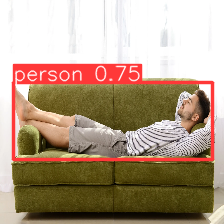

In [37]:
# Inference
results = model(images, size=YOLO_IMG_SIZE)  # includes NMS


# Results
results.print()  # print results to screen
results.show()  # display results

Preparazione dei dati da passare al modello per eseguire il predict<br>
ATTENZIONE: commentare la riga di codice 40 per passare al modello con solamente i dati calcolati dalle bounding box

In [ ]:
bounding_box_coords_list = [] # lista da riempire e utilizzare per calcolare i vari parametri in seguito

img_and_bbox2 = [] # lista contenente valori da passare al classifier

IMAGE_SIZE = 192 # dimensione di ogni immagine sarà IMAGE_SIZE * IMAGE_SIZE

ind = 0

print(results.xyxy[0])

for img in results.xyxy:
    if len(img) != 0:
        bbox_coords = []
        for i in img:
            for j in range(4):
                bbox_coords.append(int(round(i[j].item())))
            bbox_coords = resize_bbox_coord(bbox_coords,YOLO_IMG_SIZE,YOLO_IMG_SIZE,IMAGE_SIZE)
        bounding_box_coords_list.append(bbox_coords)
    else:
        del labels[ind] #rimuove label delle eventuali immagini di cui yolo non è riuscito a calcolare la bounding box
        del images[ind] #rimuove eventuali immagini di cui yolo non è riuscito a calcolare la bounding box
    ind = ind+1

for i in range(len(images)):
    images[i] = cv2.resize(images[i],(IMAGE_SIZE,IMAGE_SIZE))

print(len(bounding_box_coords_list))
for index in range(len(bounding_box_coords_list)):

    if len(bounding_box_coords_list[index]) >= 4:

        bbox_aspect_ratio = (bounding_box_coords_list[index][2]-bounding_box_coords_list[index][0])/(bounding_box_coords_list[index][3]-bounding_box_coords_list[index][1])

        normalized_bbox_width = (bounding_box_coords_list[index][2]-bounding_box_coords_list[index][0])/(images[index].shape)[1]

        normalized_bbox_bottom_cord = 1 - (bounding_box_coords_list[index][3])/((images[index].shape)[0])

        intermediate_param_list = [] # lista di appoggio per riempire lista da passare al classifier

        # if images[index].ndim == 3:
        #     images[index] = cv2.cvtColor(images[index], cv2.COLOR_RGB2GRAY) 

        #intermediate_param_list = images[index].flatten().tolist() #commentare per considerare solo dati provenienti da analisi bounding box
        intermediate_param_list.append(bbox_aspect_ratio)
        intermediate_param_list.append(normalized_bbox_width) #inserimento valori calcolati da coordinate bounding box in array contenente dati immagine corrispondente
        intermediate_param_list.append(normalized_bbox_bottom_cord)
        img_and_bbox2.append(intermediate_param_list)


tensor([[ 13.20498,  82.05025, 212.63470, 159.60852,   0.75195,   0.00000]], device='cuda:0')
1


In [51]:
print(len(img_and_bbox2))
print(len(results))
print(f"Percentuale bounding box calcolate: {100* len(img_and_bbox2)/len(results)}")

1
1
Percentuale bounding box calcolate: 100.0


Predict con il kernel linear

In [ ]:
y_predict_linear = classifier_linear.predict(img_and_bbox2) # test del classifier

print(classifier_linear)

print(classification_report(labels, y_predict_linear)) # print delle prestazioni

cmx = confusion_matrix(labels, y_predict_linear, labels=['0','1'])

plt.imshow(cmx)
plt.xticks([])
plt.yticks([])
plt.colorbar()

print('Percentage correct: ', 100*np.sum(y_predict_linear == labels)/len(labels))

print('\ncorrect labels: ', labels)
print('predicted labels: ', y_predict_linear)

predict con il kernel poly

In [ ]:
y_predict_poly = classifier_poly.predict(img_and_bbox2) # test del classifier

print(classifier_poly)

print(classification_report(labels, y_predict_poly)) # print delle prestazioni

cmx = confusion_matrix(labels, y_predict_poly, labels=['0','1'])

plt.imshow(cmx)
plt.xticks([])
plt.yticks([])
plt.colorbar()

print('Percentage correct: ', 100*np.sum(y_predict_poly == labels)/len(labels))

print('\ncorrect labels: ', labels)
print('predicted labels: ', y_predict_poly)

predict con il kernel rbf

In [ ]:
y_predict_rbf = classifier_rbf.predict(img_and_bbox2) # test del classifier

print(classifier_rbf)

print(classification_report(labels, y_predict_rbf)) # print delle prestazioni

cmx = confusion_matrix(labels, y_predict_rbf, labels=['0','1'])

plt.imshow(cmx)
plt.xticks([])
plt.yticks([])
plt.colorbar()

print('Percentage correct: ', 100*np.sum(y_predict_rbf == labels)/len(labels))

print('\ncorrect labels: ', labels)
print('predicted labels: ', y_predict_rbf)

predict con il kernel sigmoid

In [ ]:
y_predict_sigmoid = classifier_sigmoid.predict(img_and_bbox2) # test del classifier

print(classifier_sigmoid)

print(classification_report(labels, y_predict_sigmoid)) # print delle prestazioni

cmx = confusion_matrix(labels, y_predict_sigmoid, labels=['0','1'])

plt.imshow(cmx)
plt.xticks([])
plt.yticks([])
plt.colorbar()

print('Percentage correct: ', 100*np.sum(y_predict_sigmoid == labels)/len(labels))

print('\ncorrect labels: ', labels)
print('predicted labels: ', y_predict_sigmoid)

predict con SGD loss = 'hinge'

In [ ]:
y_predict_hinge = classifier_SGD_hinge.predict(img_and_bbox2) # test del classifier

print(classifier_SGD_hinge)

print(classification_report(labels, y_predict_hinge)) # print delle prestazioni

cmx = confusion_matrix(labels, y_predict_hinge, labels=['0','1'])

plt.imshow(cmx)
plt.xticks([])
plt.yticks([])
plt.colorbar()

print('Percentage correct: ', 100*np.sum(y_predict_hinge == labels)/len(labels))

print('\ncorrect labels: ', labels)
print('predicted labels: ', y_predict_hinge)

predict con SGD loss = 'squared_hinge'

In [ ]:
y_predict_squared_hinge = classifier_SGD_squared_hinge.predict(img_and_bbox2) # test del classifier

print(classifier_SGD_squared_hinge)

print(classification_report(labels, y_predict_squared_hinge)) # print delle prestazioni

cmx = confusion_matrix(labels, y_predict_squared_hinge, labels=['0','1'])

plt.imshow(cmx)
plt.xticks([])
plt.yticks([])
plt.colorbar()

print('Percentage correct: ', 100*np.sum(y_predict_squared_hinge == labels)/len(labels))

print('\ncorrect labels: ', labels)
print('predicted labels: ', y_predict_squared_hinge)

predict con Decision Tree criterion = gini

In [ ]:
y_predict_gini = classifier_tree_gini.predict(img_and_bbox2) # test del classifier

print(classifier_tree_gini)

print(classification_report(labels, y_predict_gini)) # print delle prestazioni

cmx = confusion_matrix(labels, y_predict_gini, labels=['0','1'])

plt.imshow(cmx)
plt.xticks([])
plt.yticks([])
plt.colorbar()

print('Percentage correct: ', 100*np.sum(y_predict_gini == labels)/len(labels))

print('\ncorrect labels: ', labels)
print('predicted labels: ', y_predict_gini)

predict con Decision Tree criterion = entropy

In [ ]:
y_predict_entropy = classifier_tree_entropy.predict(img_and_bbox2) # test del classifier

print(classifier_tree_entropy)

print(classification_report(labels, y_predict_entropy)) # print delle prestazioni

cmx = confusion_matrix(labels, y_predict_entropy, labels=['0','1'])

plt.imshow(cmx)
plt.xticks([])
plt.yticks([])
plt.colorbar()

print('Percentage correct: ', 100*np.sum(y_predict_entropy == labels)/len(labels))

print('\ncorrect labels: ', labels)
print('predicted labels: ', y_predict_entropy)

predict con KNeighbors

In [ ]:
y_predict_kneighbors = classifier_kneighbors.predict(img_and_bbox2) # test del classifier

print(classifier_kneighbors)

print(classification_report(labels, y_predict_kneighbors)) # print delle prestazioni

cmx = confusion_matrix(labels, y_predict_kneighbors, labels=['0','1'])

plt.imshow(cmx)
plt.xticks([])
plt.yticks([])
plt.colorbar()

print('Percentage correct: ', 100*np.sum(y_predict_kneighbors == labels)/len(labels))

print('\ncorrect labels: ', labels)
print('predicted labels: ', y_predict_kneighbors)

predict con Random Forest criterion = gini

In [ ]:
y_predict_forest_gini = classifier_random_forest_gini.predict(img_and_bbox2) # test del classifier

print(classifier_random_forest_gini)

print(classification_report(labels, y_predict_forest_gini)) # print delle prestazioni

cmx = confusion_matrix(labels, y_predict_forest_gini, labels=['0','1'])

plt.imshow(cmx)
plt.xticks([])
plt.yticks([])
plt.colorbar()

print('Percentage correct: ', 100*np.sum(y_predict_forest_gini == labels)/len(labels))

print('\ncorrect labels: ', labels)
print('predicted labels: ', y_predict_forest_gini)

predict con Random Forest criterion = entropy

In [ ]:
y_predict_forest_entropy = classifier_random_forest_entropy.predict(img_and_bbox2) # test del classifier

print(classifier_random_forest_entropy)

print(classification_report(labels, y_predict_forest_entropy)) # print delle prestazioni

cmx = confusion_matrix(labels, y_predict_forest_entropy, labels=['0','1'])

plt.imshow(cmx)
plt.xticks([])
plt.yticks([])
plt.colorbar()

print('Percentage correct: ', 100*np.sum(y_predict_forest_entropy == labels)/len(labels))

print('\ncorrect labels: ', labels)
print('predicted labels: ', y_predict_forest_entropy)